In [49]:
import numpy as np
import torch
import gpytorch
from utils import *
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# train_x = torch.linspace(0,5,88)
# train_y = torch.sin(2*np.pi*train_x) + 0.1*torch.randn(train_x.size())

train_x, train_y, true_x, true_y = loadco2(test_size=0.8, subsample_rate=5)

train_x.size()

torch.Size([88, 1])

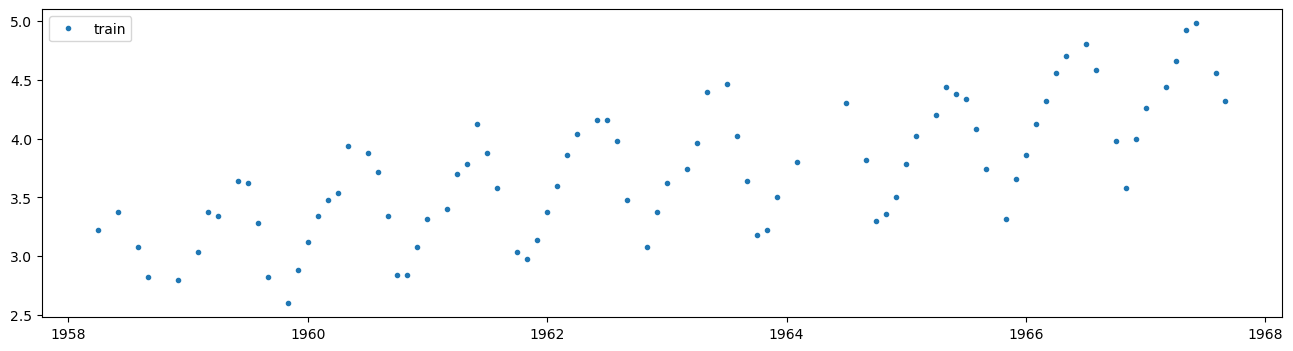

In [51]:
plt.figure(figsize=(16,4))
plt.plot(train_x, train_y,'.',label='train')
# plt.plot(test_x, test_y,'*',label='test')
plt.legend()

In [52]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [53]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = customkernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [54]:
inducing_points = train_x[::3]
model = GPModel(inducing_points=inducing_points)
# noises = torch.ones(len(inducing_points)) * 0.1
# likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noises)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# if torch.cuda.is_available():
#     model = model.cuda()
#     likelihood = likelihood.cuda()

In [55]:
# %timeit -n1 -r1
num_epochs = 100

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

import tqdm
import tqdm.notebook
import copy
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

# init_model = copy.copy(model)
# opt_loss = np.inf
# opt_model = copy.copy(model)
# opt_idx = 0

for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    # print(minibatch_iter)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
    # curr_loss = loss.item()
    # if (curr_loss < opt_loss):
    #     opt_loss = curr_loss
    #     opt_model = copy.copy(model)
    #     opt_idx = i + 1
            
# print('\n * %d th epoch gave optimal loss of %.3f' % (opt_idx, opt_loss))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

/Users/limyutaro/miniconda3/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/9 [00:00<?, ?it/s]

In [61]:
test_x = torch.linspace(1958.2,2002,1000)
# test_x = torch.linspace(0,10,1000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


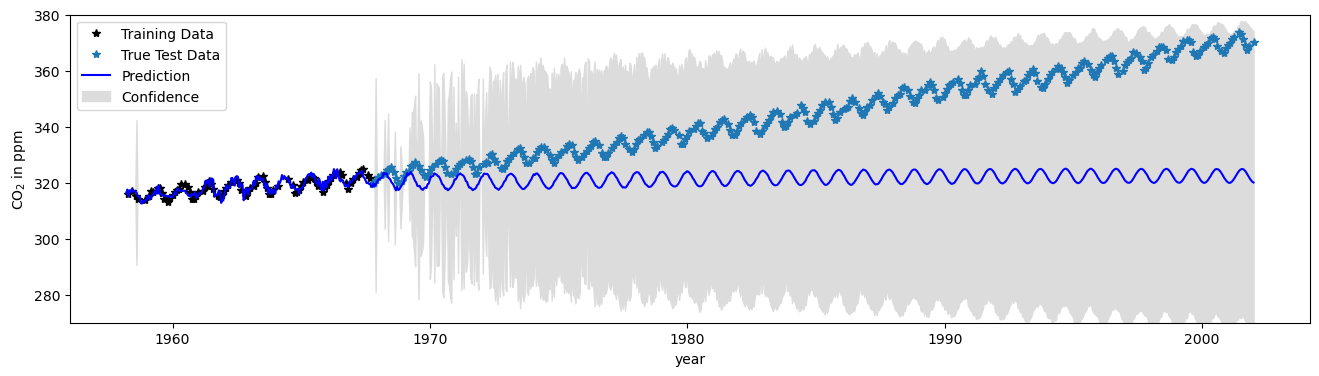

In [66]:
model.eval()
likelihood.eval()

preds = model(test_x)
means = preds.mean.cpu()
lower, upper = preds.confidence_region()

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(16, 4))
    
    # Plot training data as black stars
    ax.plot(train_x.numpy(), 300+(5*train_y.numpy()), 'k*')
    ax.plot(true_x.numpy(), 300+(5*true_y.numpy()), '*')

    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), 300+(5*means), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), 300+(5*lower.numpy()), 300+(5*upper.numpy()), color="gainsboro")
    ax.set_ylim([270, 380])
    ax.legend(['Training Data', 'True Test Data', 'Prediction', 'Confidence'])
    
    plt.xlabel("year")
    _ = plt.ylabel("CO$_2$ in ppm")
    
plt.savefig('svigp-co2-custom.eps', format='eps')
